## EDA And Sensor Selection

### Work flow

1. Read in sensor and pull associated network
2. Graphical analysis of system
3. Get sensor data and analyse for completeness etc
4. Select sensors for study
5. Output OSM network of road network and associated sensors



In [15]:
# Import modules

import pandas as pd
import osmnx as ox
import numpy as np
import shapely
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import random
import mysql.connector
from matplotlib import pyplot as plt

In [2]:
# Get sensors
sensors = pd.read_csv('Data/midas_sensor_locations.csv')

#Get network for area just for pimary roads etc
cf = '["highway"~"motorway|motorway_link|primary|trunk"]'
G = ox.graph_from_place('Kent, United Kingdom', network_type='drive', custom_filter=cf, simplify=False)
edge_attributes = ox.graph_to_gdfs(G, nodes=True)[1]

#Get edge centroids
edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y
#Add edge index
edge_attributes['edge_index'] = range(len(edge_attributes))
#Get boundary
graph_boundary=shapely.geometry.box(edge_attributes.geometry.total_bounds[0],edge_attributes.geometry.total_bounds[1],edge_attributes.geometry.total_bounds[2],edge_attributes.geometry.total_bounds[3])

/tmp/ipykernel_179826/3880505661.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
/tmp/ipykernel_179826/3880505661.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y


In [3]:
#Output network, sensor and boundary to view in qgis

edge_attributes_gdf = GeoDataFrame(edge_attributes, crs="EPSG:4326", geometry=edge_attributes['geometry'])
edge_attributes_gdf.to_file("Data/examples/kent_road_network.json", driver="GeoJSON")

sensor_points = []
for i,r in sensors.iterrows():
    sensor_points.append(Point([r['Longitude'],r['Latitude']]))
sensors['geometry'] = sensor_points

sensors_in_study = sensors[[graph_boundary.contains(point) for point in sensor_points]]

sensors_gdf = GeoDataFrame(sensors_in_study, crs="EPSG:4326", geometry=sensors_in_study['geometry'])
sensors_gdf.to_file("Data/examples/sensor_locations.json", driver="GeoJSON")

In [4]:
sensor_nearest_edges = ox.distance.nearest_edges(G, list(sensors_in_study['Longitude']), list(sensors_in_study['Latitude']), interpolate=None, return_dist=False)

In [5]:
#Randomly sample sensors to output sensor and nearest edge to check

rand_sens = random.randrange(0,len(sensors_in_study)-1)

sensor_to_check = sensors_gdf.iloc[rand_sens].to_frame().T
edge_to_check = edge_attributes.loc[sensor_nearest_edges[rand_sens]].to_frame().T#

sensor_check_gdf = GeoDataFrame(sensor_to_check, crs="EPSG:4326", geometry=sensor_to_check['geometry'])
sensor_check_gdf['geometry'].to_file("Data/examples/sensor_check.json", driver="GeoJSON")

edge_check_gdf = GeoDataFrame(edge_to_check, crs="EPSG:4326", geometry=edge_to_check['geometry'])
edge_check_gdf['geometry'].to_file("Data/examples/edge_check.json", driver="GeoJSON")

## Time Series Exploratory Data Analysis

- Completeness
- Methods for missing data imputation
- Analyse stationarity of data
- Analyse any seasonanality


### Specific To Do:

- For a random sensor:
    - Data quality checks - how are nulls represented? Any processing steps to handle this? How to measure null / missing / outliers
    - What about lanes / vehicle types?
        - Treat separately? Aggregate? Ignore (for now)? Anything else?
    - More detailed time series checks e.g., stationarity etc with analysis & interpretation

In [6]:
dec_to_min_dict = {
    0.0 : 0,
    0.25 : 15,
    0.50 : 30,
    0.75 : 45
    }

In [7]:
host = "localhost"
user = "chris"
password = "password"
database = "midas"

# Establish a database connection
connection = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

cursor = connection.cursor(buffered=True)

In [23]:
roads = []

for i in list(sensors_in_study['site_ID']):
    roads.append(i.split('/')[0])

sensors_in_study['Road'] = roads

/tmp/ipykernel_179826/4097086511.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensors_in_study['Road'] = roads


In [75]:
rand_sens = random.randrange(0,len(sensors_in_study)-1)
next_sensor = sensors_gdf.iloc[rand_sens].to_frame().T
print(next_sensor)

      site_ID Latitude Longitude count(*)                  geometry
50  M20/6526A  51.3021  0.460891   277628  POINT (0.460891 51.3021)


In [76]:
# For each sensor get a measure of completeness

#For each sensor get time-series data from 2022

sql_query = "select * from full_data where site_ID = '{}' and yr = '2022'".format(next_sensor['site_ID'].values[0])
cursor.execute(sql_query)
result = cursor.fetchall()
ts = pd.DataFrame(result, columns=[desc[0] for desc in cursor.description])

# Add date/time index

i, d = divmod((ts['time_period'] / 4), 1)
ts['Minute'] = [*map(dec_to_min_dict.get, list(d))]

years = []
months = []
days = []

for i,r in ts.iterrows():
    years.append(r['data_date'].year)
    months.append(r['data_date'].month)
    days.append(r['data_date'].day)

ts['Year'] = years
ts['Month'] = months
ts['Day'] = days
ts['Hour'] = ts['data_hour']

ts['Datetime'] = pd.to_datetime(ts[['Year', 'Month', 'Day', 'Hour', 'Minute']])
ts.set_index('Datetime', inplace=True)
ts = ts.sort_index()

#ts = ts[['Lane', 'Short_Veh', 'Long_Veh', 'Total_Flow']]

In [79]:
# Get time index from 01jan to 31 dec 2022

start_date = '2022-01-01'
end_date = '2022-12-31 23:45:00'  # End of December 2022

# Create a datetime index with 15-minute frequency
datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')
ts_columns = ['Lane 1', 'Lane 2', 'Lane 3', 'All Lanes']

# Create all vehicles data frame with 3 lanes
ts_all = pd.DataFrame(index = datetime_index, columns = ts_columns)

ts_all['Lane 1'] = ts[ts['Lane'] == 'lane1']['Total_Flow']
ts_all['Lane 2'] = ts[ts['Lane'] == 'lane2']['Total_Flow']
ts_all['Lane 3'] = ts[ts['Lane'] == 'lane3']['Total_Flow']
ts_all['All Lanes'] = ts.groupby(ts.index).sum('Total_Flow')['Total_Flow']

#Add Weekend Flag
ts_all['Weekend'] = ts_all.index.dayofweek >= 5


/tmp/ipykernel_179826/3135284326.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')


-----------------
Next Columns : Lane 1
Count of zeros : 375
Rate of zeros : 1.1%
Count of nulls : 13674
Rate of nulls : 39.0%
Count of outliers : 815
Rate of outliers : 2.3%
-----------------


-----------------
Next Columns : Lane 2
Count of zeros : 345
Rate of zeros : 1.0%
Count of nulls : 13717
Rate of nulls : 39.1%
Count of outliers : 32
Rate of outliers : 0.1%
-----------------


-----------------
Next Columns : Lane 3
Count of zeros : 354
Rate of zeros : 1.0%
Count of nulls : 13853
Rate of nulls : 39.5%
Count of outliers : 121
Rate of outliers : 0.3%
-----------------


-----------------
Next Columns : All Lanes
Count of zeros : 541
Rate of zeros : 1.5%
Count of nulls : 1173
Rate of nulls : 3.3%
Count of outliers : 1518
Rate of outliers : 4.3%
-----------------




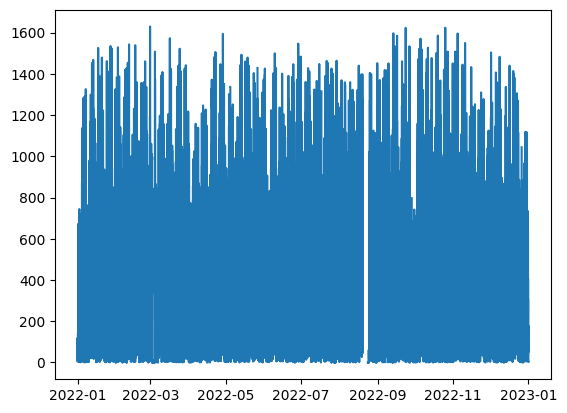

In [78]:
# For each column - count zeros, nulls and outliers

len_ts = len(ts_all)

for col in ts_columns:
    print('-----------------')
    print('Next Columns : {}'.format(col))
    #Count zeros
    zero_count = (ts_all[col] == 0).sum()
    print('Count of zeros : {}'.format(zero_count))
    print('Rate of zeros : {:.1%}'.format(zero_count / len_ts))

    # Count nulls
    null_count = ts_all[col].isnull().sum()
    print('Count of nulls : {}'.format(null_count))
    print('Rate of nulls : {:.1%}'.format(null_count / len_ts))

    # Identify and count outliers (assuming values more than 2 standard deviations from the mean are outliers)
    mean_value = ts_all[col].mean()
    std_dev = ts_all[col].std()
    outlier_count = ((ts_all[col] > mean_value + 2 * std_dev) | (ts_all[col] < mean_value - 2 * std_dev)).sum()
    print('Count of outliers : {}'.format(outlier_count))
    print('Rate of outliers : {:.1%}'.format(outlier_count / len_ts))
    print('-----------------')
    print()
    print()
    

plt.plot(ts_all['All Lanes'])
plt.show()

### Time Series Analysis

- Summary stats over time. Show summarised boxplots over time.
- Seasonal decomposition
- Auto correlation / partial auto correlation analysis
- Stationary analysis
- Time-series decomposition
- Heapmaps of data

# Summary Statistics Over Time

to do:
- Completeness over time

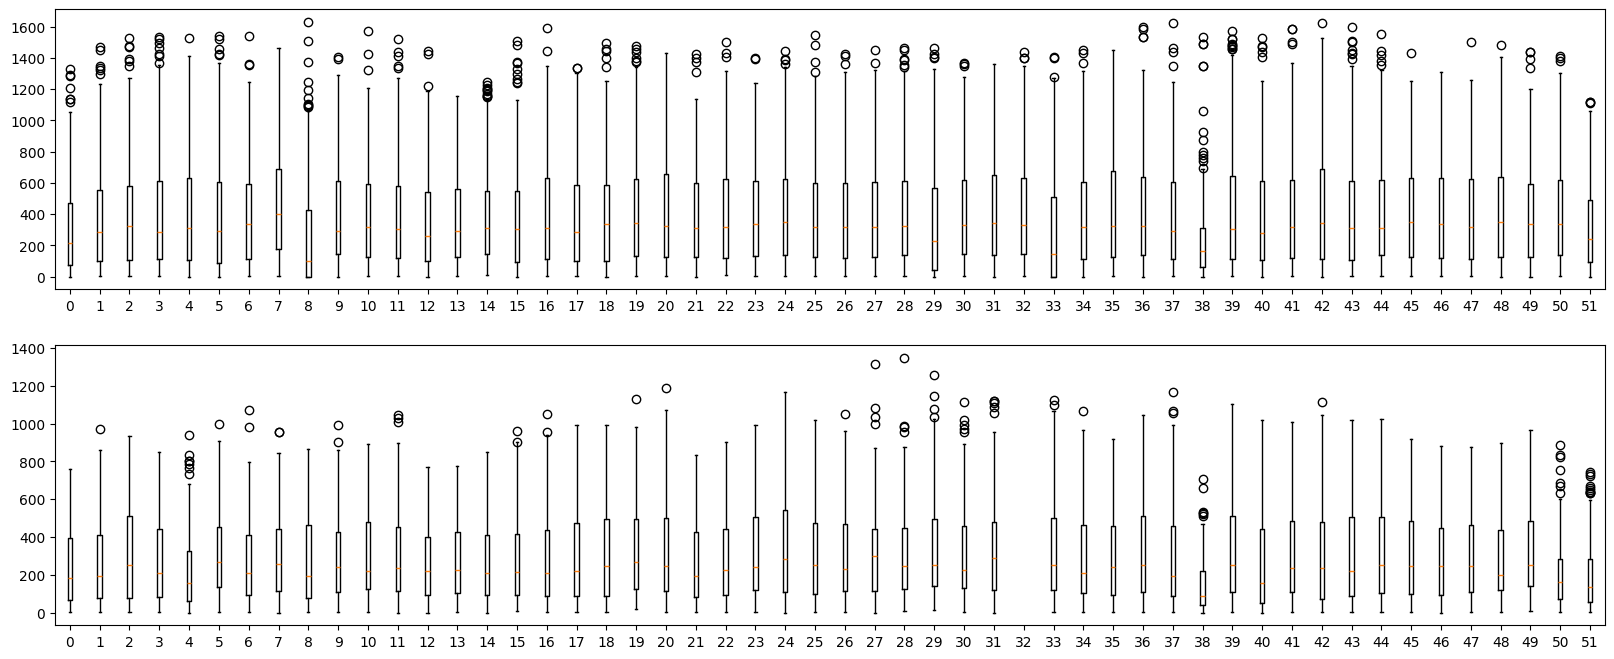

In [119]:
fig, ax = plt.subplots(2,1, figsize = [20,8])

x_position = 0

for i in range(1,53):
    week_data = ts_all[ts_all.index.isocalendar().week == i]
    ax[0].boxplot(week_data[week_data['Weekend'] == False]['All Lanes'].dropna(), positions=[x_position])
    x_position += 1

x_position = 0
for i in range(1,53):
    week_data = ts_all[ts_all.index.isocalendar().week == i]
    ax[1].boxplot(week_data[week_data['Weekend'] == True]['All Lanes'].dropna(), positions=[x_position])
    x_position += 1
    
plt.show()

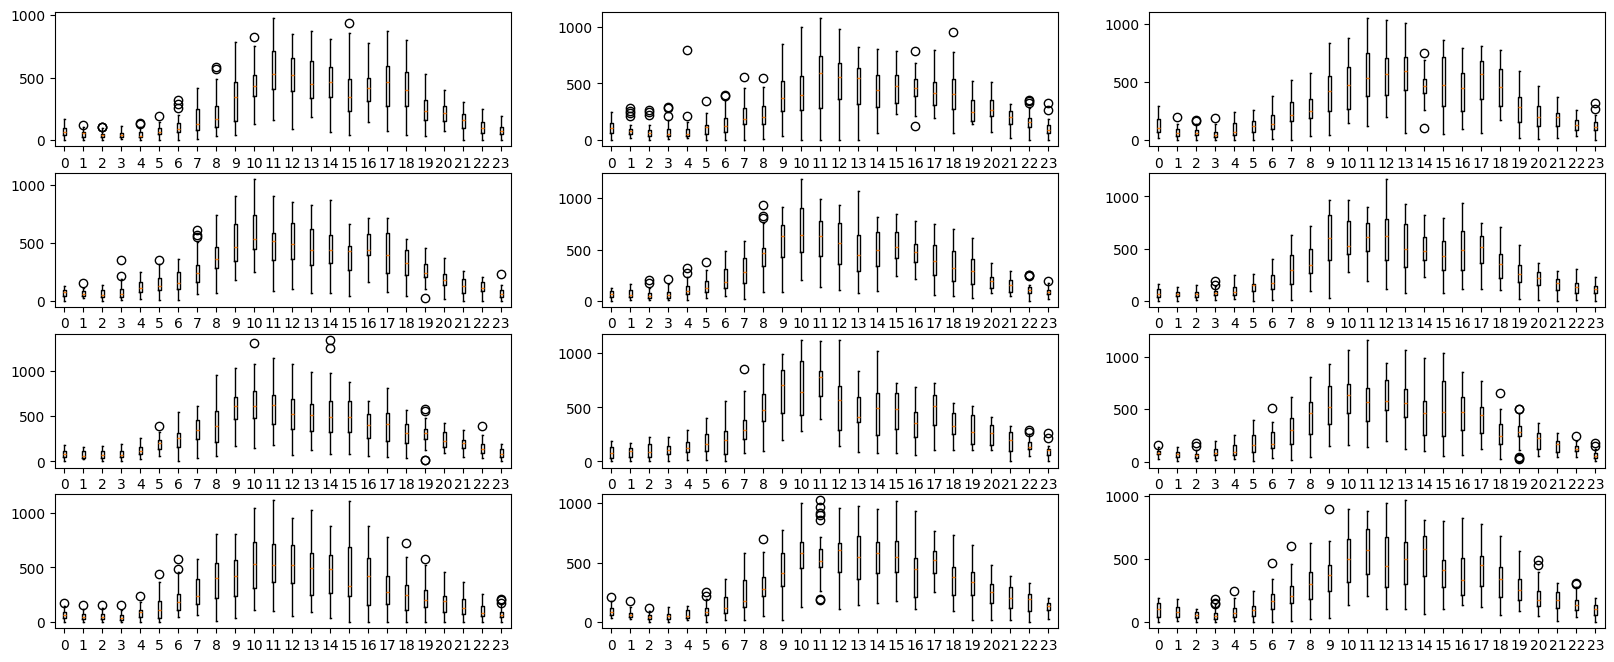

In [139]:
# In jan what does an average day looks like?

fig, ax = plt.subplots(4,3, figsize = [20,8])

ax_across = 0
ax_down = 0

for m in range(1,13):
    
    x_position = 0
    
    for h in range(24):
        
        month_hour_data = ts_all[(ts_all.index.month == m) & (ts_all.index.hour == h)]
        ax[ax_down,ax_across].boxplot(month_hour_data[month_hour_data['Weekend'] == True]['All Lanes'].dropna(), positions=[x_position])
        x_position += 1

    if ax_across < 2:
        ax_across += 1
    else:
        ax_across = 0
        ax_down += 1
        
plt.show()
    

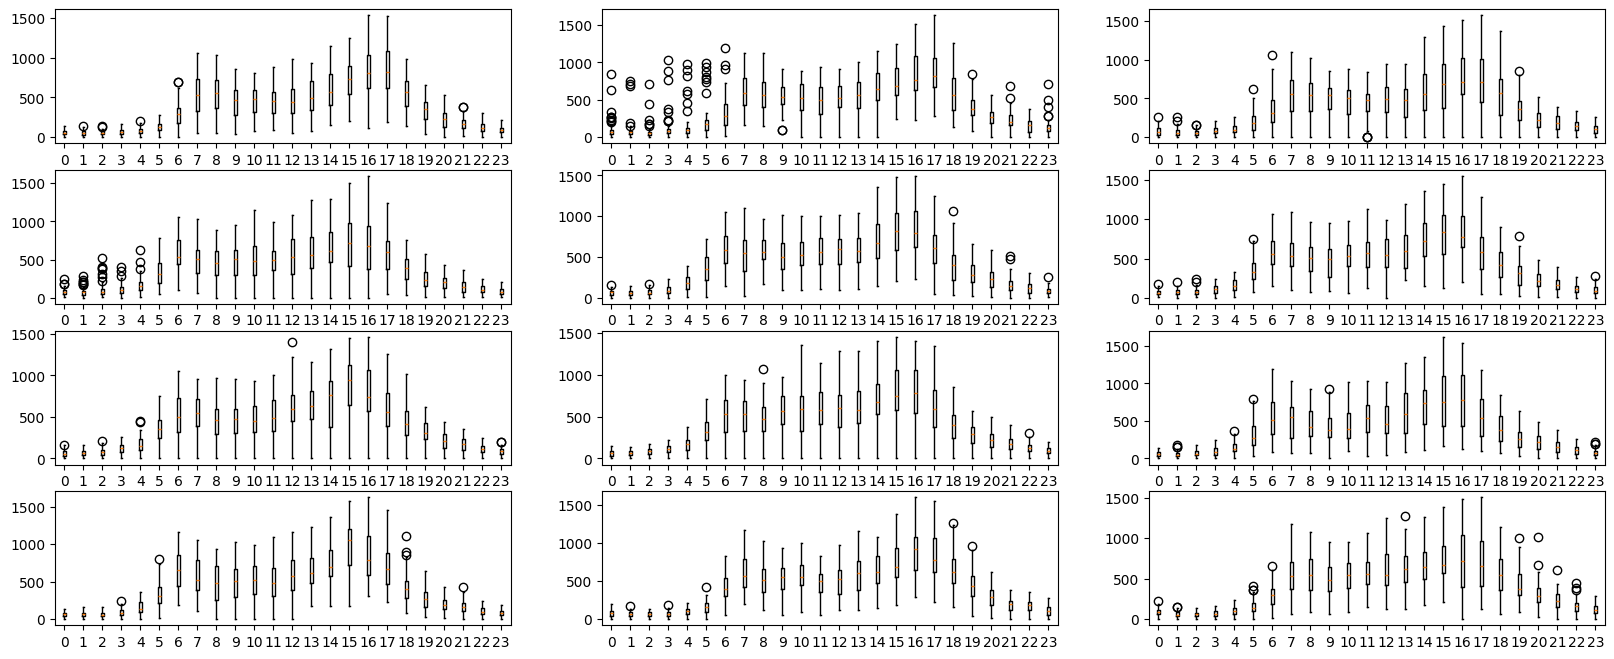

In [140]:
# In jan what does an average day looks like?

fig, ax = plt.subplots(4,3, figsize = [20,8])

ax_across = 0
ax_down = 0

for m in range(1,13):
    
    x_position = 0
    
    for h in range(24):
        
        month_hour_data = ts_all[(ts_all.index.month == m) & (ts_all.index.hour == h)]
        ax[ax_down,ax_across].boxplot(month_hour_data[month_hour_data['Weekend'] == False]['All Lanes'].dropna(), positions=[x_position])
        x_position += 1

    if ax_across < 2:
        ax_across += 1
    else:
        ax_across = 0
        ax_down += 1
        
plt.show()